# Toy Latent Variable Model
Consider a simple latent variable model where we have observations $y_1, \dots, y_n \in \mathbb{R}^d$ drawn from
    \begin{align*}
        z|\theta &\sim \mathcal{N}(\cdot;\theta \textsf{1}_d, \textsf{Id}_d)\\
        y|z &\sim \mathcal{N}(\cdot;z, \textsf{Id}_d)
    \end{align*}
    where $\theta\in\mathbb{R}$ and $\textsf{1}_d, \textsf{Id}_d$ denote the $d$-dimensional vector of ones and the $d\times d$ identity matrix respectively.

In [1]:
# standard libraries
import importlib
from matplotlib import pyplot as plt
import numpy as np
from scipy.stats import norm
from scipy import linalg, stats, optimize
import time
import sys
sys.path.append('/Users/francescacrucinio/Documents/MD_LVM')

import md_lvm
importlib.reload(md_lvm)

<module 'md_lvm' from '/Users/francescacrucinio/Documents/PAPERS/SUBMITTED/MD_LVM/md_lvm.py'>

## Data

In [2]:
D = 50  # Dimensionality of latent variables.
thdata = 1  # Parameter value used to generate the data.

# Generate the data:
y = np.random.normal(0, 1, (D, 1)) + np.random.normal(thdata, 1, (D, 1))

In [3]:
# get MLE
theta_mle = np.mean(y)
theta_mle

1.0439832634916102

In [4]:
#Set approximation parameters:
Niter = 2000  # Number of steps.
N = 200  # Number of particles.

th0 = np.array([0.0])  # Initial parameter guess.
X0 = np.random.normal(size = (D, N))  # Initial particle cloud.

In [5]:
gamma = 0.01

In [6]:
start = time.time()
th_md, X_md, W_md = md_lvm.md_toy_lvm(y, gamma, Niter, N, th0, X0.T)
end = time.time()
print(end-start)

471.30778789520264


In [7]:
start = time.time()
th_md2, X_md2, W_md2 = md_lvm.md_toy_lvm_fast(y, gamma, Niter, N, th0, X0.T)
end = time.time()
print(end-start)

3.870500087738037


In [11]:
## Multivariate KL
def kl_mvn(m0, S0, m1, S1):
    """
    Kullback-Liebler divergence from Gaussian pm,pv to Gaussian qm,qv.
    Also computes KL divergence from a single Gaussian pm,pv to a set
    of Gaussians qm,qv.
    

    From wikipedia
    KL( (m0, S0) || (m1, S1))
         = .5 * ( tr(S1^{-1} S0) + log |S1|/|S0| + 
                  (m1 - m0)^T S1^{-1} (m1 - m0) - N )
    """
    # store inv diag covariance of S1 and diff between means
    N = m0.shape[0]
    iS1 = np.linalg.inv(S1)
    diff = m1 - m0

    # kl is made of three terms
    tr_term   = np.trace(iS1 @ S0)
    det_term  = np.log(np.linalg.det(S1)/np.linalg.det(S0)) #np.sum(np.log(S1)) - np.sum(np.log(S0))
    quad_term = diff.T @ np.linalg.inv(S1) @ diff #np.sum( (diff*diff) * iS1, axis=1)
    #print(tr_term,det_term,quad_term)
    return .5 * (tr_term + det_term + quad_term - N) 

kl_md = np.zeros(Niter)

kl_md2 = np.zeros(Niter)

kl_between1 = np.zeros(Niter)
kl_between2 = np.zeros(Niter)

mu_target = 0.5*(np.mean(y)+y)[:, 0]
sigma_target = 0.5*np.eye(D)
for i in range(Niter):
    mean_md = np.sum(X_md[i, :, :].T*W_md[i, :], axis = 1)
    var_md = np.cov(X_md[i, :, :].T, ddof = 0, aweights = W_md[i, :])
    kl_md[i] = kl_mvn(mean_md, var_md, mu_target, sigma_target)
    
    mean_md2 = np.sum(X_md2[i, :, :].T*W_md2[i, :], axis = 1)
    var_md2 = np.cov(X_md2[i, :, :].T, ddof = 0, aweights = W_md2[i, :])
    kl_md2[i] = kl_mvn(mean_md2, var_md2, mu_target, sigma_target)
    
    kl_between1[i] = kl_mvn(mean_md, var_md, mean_md2, var_md2)
    kl_between2[i] = kl_mvn(mean_md2, var_md2, mean_md, var_md)

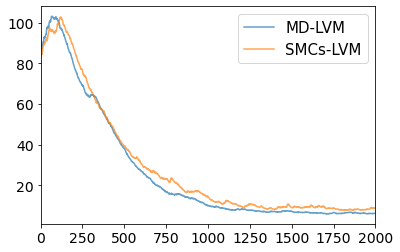

In [18]:
# Plot KL from posterior as a function of step number k:
plt.plot(kl_md, label='MD-LVM', alpha = 0.7)
plt.plot(kl_md2, label='SMCs-LVM', alpha = 0.7)
plt.legend(fontsize = 15);
plt.xlim([0, Niter]);
plt.xticks(fontsize=14);
plt.yticks(fontsize=14);
# plt.savefig('toy_optimal_gamma_kl.pdf', bbox_inches="tight")

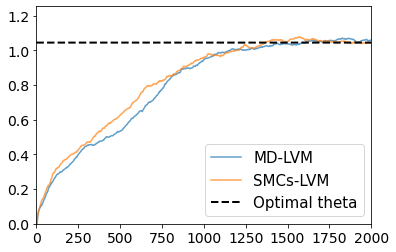

In [16]:
# Plot parameter estimates as a function of step number k:
plt.plot(th_md, label='MD-LVM', alpha = 0.7);
plt.plot(th_md2, label='SMCs-LVM', alpha = 0.7);
plt.plot(y.mean()*np.ones(Niter), label='Optimal theta', c = 'black', linestyle = 'dashed', lw = 2);
plt.legend(loc='lower right', fontsize = 15);
plt.ylim([0, 1.2*y.mean()]);
plt.xlim([0, Niter]);
plt.xticks(fontsize=14);
plt.yticks(fontsize=14);
# plt.savefig('toy_optimal_gamma.pdf', bbox_inches="tight")

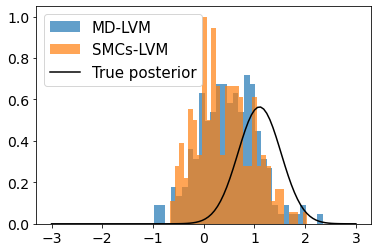

In [28]:
plt.hist(X_md[Niter-1, :, 35], density = True, bins = 30, weights = W_md[Niter-1, :], label='MD-LVM', alpha = 0.7);
plt.hist(X_md2[Niter-1, :, 35], density = True, bins = 30, weights = W_md2[Niter-1, :], label='SMCs-LVM', alpha = 0.7);
plt.plot(np.linspace(-3, 3, 100), norm.pdf(np.linspace(-5, 5, 100), scale = np.sqrt(0.5), 
        loc = 0.5*(np.mean(y)+y[0])), label = 'True posterior',
        c = 'black');
plt.legend(fontsize = 15);
plt.xticks(fontsize=14);
plt.yticks(fontsize=14);
# plt.savefig('toy_optimal_gamma_posterior2.pdf', bbox_inches="tight")

## Comparison MD-LVM and SMCs-LVM

In [20]:
## Marginal KL
def KL(mu, sigma, mu_target, sigma_target):
    return 0.5*np.log(sigma_target/sigma)+(sigma+(mu-mu_target)**2)/(2*sigma_target) - 0.5

mean_md = np.zeros((Niter, D))
var_md = np.zeros((Niter, D))
kl_md = np.zeros((Niter, D))

mean_md2 = np.zeros((Niter, D))
var_md2 = np.zeros((Niter, D))
kl_md2 = np.zeros((Niter, D))

w1_between = np.zeros((Niter, D))

sigma_target = 0.5
for i in range(Niter):
    for j in range(D):
        mu_target = 0.5*(np.mean(y)+y[j])
        mean_md[i, j] = np.sum(X_md[i, :, j]*W_md[i, :])
        var_md[i, j] = np.sum(X_md[i, :, j]**2*W_md[i, :])-mean_md[i, j]**2
        kl_md[i, j] = KL(mean_md[i, j], var_md[i, j], mu_target, sigma_target)[0]

        mean_md2[i, j] = np.sum(X_md2[i, :, j]*W_md2[i, :])
        var_md2[i, j] = np.sum(X_md2[i, :, j]**2*W_md2[i, :])-mean_md2[i, j]**2
        kl_md2[i, j] = KL(mean_md2[i, j], var_md2[i, j], mu_target, sigma_target)[0]
        
        w1_between[i, j] = stats.wasserstein_distance(X_md2[i, :, j], X_md[i, :, j], W_md2[i, :], W_md[i, :])

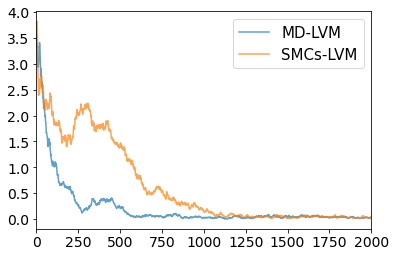

In [26]:
# Plot KL from posterior as a function of step number k:
plt.plot(kl_md[:, 4], label='MD-LVM', alpha = 0.7)
plt.plot(kl_md2[:, 4], label='SMCs-LVM', alpha = 0.7)
plt.legend(fontsize = 15);
plt.xlim([0, Niter]);
plt.xticks(fontsize=14);
plt.yticks(fontsize=14);

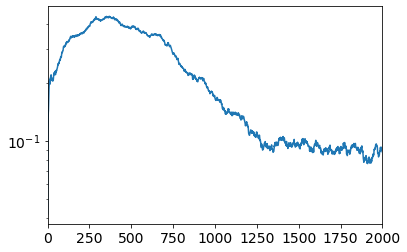

In [31]:
plt.semilogy(np.mean(w1_between, axis = 1));
plt.xlim([0, Niter]);
plt.xticks(fontsize=14);
plt.yticks(fontsize=14);
# plt.savefig('toy_optimal_gamma_w1.pdf', bbox_inches="tight")

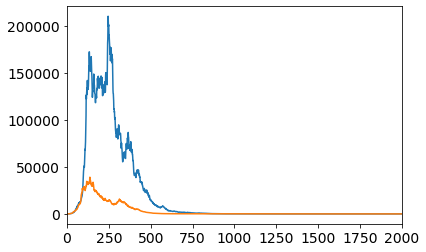

In [23]:
# Plot KL from posterior as a function of step number k:
plt.plot(kl_between1)
plt.plot(kl_between2)
# plt.legend(fontsize = 15);
plt.xlim([0, Niter]);
plt.xticks(fontsize=14);
plt.yticks(fontsize=14);